尝试展示一下现有数据有什么特点, 实际上看来就是没有什么作用, 毕竟和集成电路没有什么关系

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_exports = pd.read_excel(r'..\..\data\raw\Q3\前三问出口数据整理版.xlsx')
df_exports.head()

# delete the last 
df_exports = df_exports.drop('2025',axis=1).melt(id_vars=['Country'],var_name='Year',value_name='Exports')
df_exports.head()

# plot the data

# df_imports = pd.read_excel(r'..\..\data\raw\Q3\前三问进口数据整理版.xlsx')
# df_imports.head()



,Country,Year,Exports
0,Afghanistan,2020,215724
1,Albania,2020,46717
2,Algeria,2020,50300426
3,Angola,2020,0
4,Anguilla,2020,3480


使用冲击评估的方法来研究关税的影响:
1. 时间序列来预测无关税条件下的进口增长
2. 通过历史数据构建弹性函数
3. 明确弹性函数对时间序列分析下的进口增长的影响

In [7]:
# ==================================================
# 完整版：芯片数据随机森林+博弈论分析（适配你的数据）
# 运行顺序：直接执行，按提示输入列序号即可
# 保存路径：D:/__MXM/study/竞赛/数模/亚太杯/数据/问题3
# ==================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# ========================
# 1. 全局配置（无需修改）
# ========================
# 中文字体设置
plt.rcParams['font.sans-serif'] = ['SimHei', 'WenQuanYi Zen Hei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 100

# 数据路径（你的实际路径，已固定）
DATA_PATH = r'..\..\data\raw\Q3\问题三季度数据.xlsx'
SAVE_DIR = os.path.dirname(DATA_PATH)  # 结果保存在数据同目录
print(f"📁 数据目录：{SAVE_DIR}")
print(f"📄 数据文件：{os.path.basename(DATA_PATH)}")


# ========================
# 2. 第一步：数据读取与彻底清理（解决字符串问题）
# ========================
print("\n" + "="*70)
print("【第一步：数据读取与清理（确保纯数值）】")
print("="*70)

# 2.1 读取原始数据
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"❌ 文件不存在！请检查路径：{DATA_PATH}")
df_raw = pd.read_excel(DATA_PATH)
print(f"✅ 原始数据读取完成：{df_raw.shape}（行×列）")

# 2.2 清理注释行（删除含“注:”“为了防止倒卖”等文本的行）
comment_markers = ['注:', '说明:', '备注:', '为了防止倒卖', '数据来源:']
non_comment_mask = df_raw.apply(
    lambda row: not any(marker in str(cell) for marker in comment_markers for cell in row),
    axis=1
)
df_cleaned = df_raw[non_comment_mask].copy()
print(f"✅ 注释行清理：删除{len(df_raw)-len(df_cleaned)}行，剩余{len(df_cleaned)}行")

# 2.3 清理单元格文本（提取纯数值，解决“字符串转浮点数”错误）
def extract_numeric(cell):
    """从单元格提取纯数值，无法提取则返回NaN"""
    if pd.isna(cell):
        return np.nan
    if isinstance(cell, (int, float)):
        return cell
    cell_str = str(cell).strip()
    # 匹配纯数字（整数/小数/负数）
    num_match = re.search(r'^-?\d+(\.\d+)?$', cell_str)
    if num_match:
        return float(num_match.group())
    # 清理特殊符号（如“50+”→50，“≥14nm”→14）
    clean_str = re.sub(r'[^\d.-]', '', cell_str)
    if clean_str and re.match(r'^-?\d+(\.\d+)?$', clean_str):
        return float(clean_str)
    return np.nan

# 识别所有数值列（能提取出数值的列）
numeric_cols = []
for col in df_cleaned.columns:
    df_cleaned[col] = df_cleaned[col].apply(extract_numeric)
    # 超过50%的值为数值，则视为数值列
    if df_cleaned[col].notna().mean() > 0.5:
        numeric_cols.append(col)

# 保留数值列并填充NaN（用中位数，避免极端值影响）
df_final = df_cleaned[numeric_cols].copy()
for col in df_final.columns:
    df_final[col].fillna(df_final[col].median(), inplace=True)
df_final = df_final.astype(float)  # 强制转为float类型
print(f"✅ 数值列清理完成：共{len(df_final.columns)}个纯数值列")
print(f"   数值列列表：{df_final.columns.tolist()}")

# 保存清理后的数据（备用）
cleaned_save_path = os.path.join(SAVE_DIR, '清理后_纯数值数据.xlsx')
df_final.to_excel(cleaned_save_path, index=False)
print(f"✅ 清理后数据已保存：{os.path.basename(cleaned_save_path)}")


# ========================
# 3. 第二步：手动选择特征列与目标列（解决列名不匹配）
# ========================
print("\n" + "="*70)
print("【第二步：手动选择列（按提示输入序号）】")
print("="*70)

# 3.1 显示所有可用数值列，让用户选择“特征列”（影响因素）
print("\n📊 可用的数值列（请选择【特征列】——影响结果的因素，如关税率、补贴）：")
for i, col in enumerate(df_final.columns, 1):
    print(f"   {i:2d}. {col}")

# 交互选择特征列（输入序号，逗号分隔，如“1,3,5”）
while True:
    feat_input = input("\n请输入特征列序号（用英文逗号分隔，如1,2）：")
    try:
        # 解析输入的序号（转为0-based索引）
        feat_indices = [int(x.strip())-1 for x in feat_input.split(',')]
        feature_cols = [df_final.columns[i] for i in feat_indices]
        # 验证序号有效
        if len(feature_cols) == 0 or any(col not in df_final.columns for col in feature_cols):
            raise ValueError
        print(f"✅ 已选择特征列：{feature_cols}")
        break
    except:
        print("❌ 输入错误！请用英文逗号分隔序号（如1,2,3），且序号在上述列表中")

# 3.2 选择“目标列”（要分析的结果，如行业增长率、自给率）
print("\n🎯 可用的数值列（请选择【目标列】——要分析的结果，如增长率、自给率）：")
for i, col in enumerate(df_final.columns, 1):
    print(f"   {i:2d}. {col}")

while True:
    target_input = input("\n请输入目标列序号（仅选1个，如4）：")
    try:
        target_idx = int(target_input.strip())-1
        target_col = df_final.columns[target_idx]
        print(f"✅ 已选择目标列：{target_col}")
        break
    except:
        print("❌ 输入错误！请输入单个有效序号（如4）")


# ========================
# 4. 第三步：随机森林训练（提取特征权重）
# ========================
print("\n" + "="*70)
print("【第三步：随机森林模型训练】")
print("="*70)

# 4.1 准备训练数据
X = df_final[feature_cols]  # 特征矩阵
y = df_final[target_col]    # 目标变量
print(f"📥 训练数据：特征列{X.shape[1]}个，样本{X.shape[0]}条")

# 4.2 划分训练集/测试集（8:2）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# 4.3 训练随机森林（参数优化，避免过拟合）
rf_model = RandomForestRegressor(
    n_estimators=100,    # 100棵决策树（稳定）
    max_depth=5,         # 限制树深（防止过拟合）
    min_samples_split=5, # 节点分裂最小样本数
    random_state=42      # 结果可复现
)
rf_model.fit(X_train, y_train)

# 4.4 模型评估（R²：越接近1，解释力越强）
y_pred = rf_model.predict(X_test)
r2_score_val = r2_score(y_test, y_pred)
print(f"📈 模型评估：测试集R² = {r2_score_val:.3f}（≥0.3即有效）")

# 4.5 提取特征重要性（核心输出，供博弈论使用）
feature_importance = pd.DataFrame({
    'Feature_Name': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n🔍 特征重要性排名（权重越高，影响越大）：")
for idx, row in feature_importance.iterrows():
    print(f"   {row.name+1:2d}. {row['Feature_Name']}：{row['Importance']:.3f}")

# 4.6 保存随机森林结果
rf_importance_path = os.path.join(SAVE_DIR, '随机森林_特征权重结果.xlsx')
feature_importance.to_excel(rf_importance_path, index=False)
print(f"\n✅ 特征权重已保存：{os.path.basename(rf_importance_path)}")

# 绘制特征重要性图
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature_Name'], feature_importance['Importance'], color='#4ECDC4')
plt.xlabel('特征重要性权重')
plt.title(f'随机森林特征重要性（目标列：{target_col}）')
plt.gca().invert_yaxis()  # 倒序：权重高的在上面
plt.tight_layout()
rf_plot_path = os.path.join(SAVE_DIR, '随机森林_特征重要性图.png')
plt.savefig(rf_plot_path)
print(f"✅ 特征重要性图已保存：{os.path.basename(rf_plot_path)}")


# ========================
# 5. 第四步：博弈论分析（基于随机森林权重）
# ========================
print("\n" + "="*70)
print("【第四步：博弈论纳什均衡求解】")
print("="*70)

# 5.1 读取随机森林权重结果
if not os.path.exists(rf_importance_path):
    raise FileNotFoundError(f"❌ 权重文件不存在：{rf_importance_path}")
importance_df = pd.read_excel(rf_importance_path)
print(f"📥 读取特征权重：共{len(importance_df)}个特征")

# 5.2 手动选择博弈相关特征（关税、补贴——博弈的核心策略）
print("\n⚖️  请选择博弈核心特征（从以下特征中选2个：关税相关、补贴相关）：")
for i, row in importance_df.iterrows():
    print(f"   {i+1:2d}. {row['Feature_Name']}（权重：{row['Importance']:.3f}）")

# 选择“关税相关特征”
while True:
    tariff_input = input("\n请输入【关税相关特征】序号（如1）：")
    try:
        tariff_idx = int(tariff_input.strip())-1
        tariff_feat = importance_df.iloc[tariff_idx]['Feature_Name']
        tariff_weight = importance_df.iloc[tariff_idx]['Importance']
        print(f"✅ 已选关税特征：{tariff_feat}（权重：{tariff_weight:.3f}）")
        break
    except:
        print("❌ 输入错误！请输入单个有效序号")

# 选择“补贴相关特征”
while True:
    subsidy_input = input("请输入【补贴相关特征】序号（如2）：")
    try:
        subsidy_idx = int(subsidy_input.strip())-1
        subsidy_feat = importance_df.iloc[subsidy_idx]['Feature_Name']
        subsidy_weight = importance_df.iloc[subsidy_idx]['Importance']
        print(f"✅ 已选补贴特征：{subsidy_feat}（权重：{subsidy_weight:.3f}）")
        break
    except:
        print("❌ 输入错误！请输入单个有效序号")

# 5.3 博弈模型设定（芯片行业场景）
# 博弈双方与策略
players = {
    '美国政府': ['关税策略', '补贴策略', '混合策略'],
    '全球市场/中国': ['买入美国芯片', '反制措施', '部分买入+部分反制']
}
us_strats = players['美国政府']
cn_strats = players['全球市场/中国']

# 芯片领域划分（按制程，贴合行业实际）
chip_domains = {
    '高端芯片': {'名称': '高端芯片（<10nm）', '经济权重占比': 0.3, '安全权重占比': 0.7},
    '中端芯片': {'名称': '中端芯片（10-28nm）', '经济权重占比': 0.5, '安全权重占比': 0.5},
    '低端芯片': {'名称': '低端芯片（>28nm）', '经济权重占比': 0.7, '安全权重占比': 0.3}
}

# 5.4 支付函数（计算美国得分，中国得分=10-美国得分）
def calc_payoff(domain, us_strat, cn_strat):
    """
    支付得分 = 经济贡献 + 安全贡献
    经济贡献 = 基础得分 × 策略调整 × 特征权重 × 领域经济占比
    安全贡献 = 基础得分 × 策略调整 × 特征权重 × 领域安全占比
    """
    # 1. 基础得分（按策略和领域设定）
    if us_strat == '关税策略':
        # 关税：低端经济收益高，高端安全收益低
        base_econ = 9 if '低端' in domain['名称'] else (6 if '中端' in domain['名称'] else 4)
        base_sec = 4 if '高端' in domain['名称'] else (6 if '中端' in domain['名称'] else 8)
        econ_w = tariff_weight  # 关税的经济权重
        sec_w = tariff_weight * 0.8  # 关税对安全的影响稍弱
    elif us_strat == '补贴策略':
        # 补贴：高端安全收益高，低端经济收益低
        base_econ = 4 if '低端' in domain['名称'] else (6 if '中端' in domain['名称'] else 9)
        base_sec = 9 if '高端' in domain['名称'] else (6 if '中端' in domain['名称'] else 4)
        econ_w = subsidy_weight * 0.8  # 补贴对经济的影响稍弱
        sec_w = subsidy_weight  # 补贴的安全权重
    else:  # 混合策略
        base_econ = 7
        base_sec = 7
        econ_w = (tariff_weight + subsidy_weight) / 2
        sec_w = (tariff_weight + subsidy_weight) / 2

    # 2. 中国策略调整系数（反制降分，买入升分）
    if cn_strat == '反制措施':
        adjust = 0.6  # 反制：美国得分降40%
    elif cn_strat == '买入美国芯片':
        adjust = 1.3  # 买入：美国得分升30%
    else:
        adjust = 0.9  # 部分买入：微降10%

    # 3. 计算最终得分
    econ_contrib = base_econ * adjust * econ_w * domain['经济权重占比']
    sec_contrib = base_sec * adjust * sec_w * domain['安全权重占比']
    return round(econ_contrib + sec_contrib, 2)

# 5.5 求解每个领域的纳什均衡
game_results = []
for domain_name, domain_info in chip_domains.items():
    # 构建支付矩阵（美国得分）
    payoff_mat = np.zeros((len(us_strats), len(cn_strats)))
    for i, us_strat in enumerate(us_strats):
        for j, cn_strat in enumerate(cn_strats):
            payoff_mat[i, j] = calc_payoff(domain_info, us_strat, cn_strat)

    # 标记最优策略：美国选最大得分，中国选最小得分（中国得分=10-美国得分）
    us_best = np.apply_along_axis(lambda x: x == x.max(), 0, payoff_mat)  # 美国最优（每列最大）
    cn_best = np.apply_along_axis(lambda x: x == x.min(), 1, payoff_mat)  # 中国最优（每行最小）
    eq_mask = us_best & cn_best  # 纳什均衡：双方均最优

    # 提取均衡策略
    equilibria = []
    for i in range(len(us_strats)):
        for j in range(len(cn_strats)):
            if eq_mask[i, j]:
                equilibria.append({
                    '美国策略': us_strats[i],
                    '中国策略': cn_strats[j],
                    '美国得分': payoff_mat[i, j],
                    '中国得分': round(10 - payoff_mat[i, j], 2)
                })

    game_results.append({
        '芯片领域': domain_info['名称'],
        '支付矩阵': payoff_mat,
        '纳什均衡': equilibria
    })
    print(f"\n📊 {domain_info['名称']}：")
    print(f"   支付矩阵（美国得分）：\n{payoff_mat.round(2)}")
    print(f"   纳什均衡策略（共{len(equilibria)}组）：")
    for eq in equilibria:
        print(f"     - 美国：{eq['美国策略']} | 中国：{eq['中国策略']} | 美得分：{eq['美国得分']}")

# 5.6 保存博弈结果
# 整理均衡结果
eq_final = []
for res in game_results:
    for eq in res['纳什均衡']:
        eq_final.append({
            '芯片领域': res['芯片领域'],
            '美国最优策略': eq['美国策略'],
            '中国最优策略': eq['中国策略'],
            '美国支付得分': eq['美国得分'],
            '中国支付得分': eq['中国得分']
        })
eq_df = pd.DataFrame(eq_final)

# 保存Excel
game_save_path = os.path.join(SAVE_DIR, '博弈论_纳什均衡结果.xlsx')
eq_df.to_excel(game_save_path, index=False)
print(f"\n✅ 博弈结果已保存：{os.path.basename(game_save_path)}")

# 绘制支付矩阵热力图
plt.figure(figsize=(18, 5))
for i, res in enumerate(game_results):
    plt.subplot(1, 3, i+1)
    sns.heatmap(
        res['支付矩阵'],
        annot=True, fmt='.2f',
        xticklabels=cn_strats,
        yticklabels=us_strats,
        cmap='YlOrRd',
        cbar=False,
        annot_kws={'fontsize': 9}
    )
    # 标注纳什均衡位置（红色星号）
    for j in range(len(us_strats)):
        for k in range(len(cn_strats)):
            if eq_mask[j, k]:
                plt.text(k+0.5, j+0.5, '*', ha='center', va='center', color='red', fontsize=16)
    plt.title(res['芯片领域'], fontsize=10)
    plt.xlabel('中国策略', fontsize=9)
    plt.ylabel('美国策略', fontsize=9)

game_plot_path = os.path.join(SAVE_DIR, '博弈论_支付矩阵热力图.png')
plt.tight_layout()
plt.savefig(game_plot_path)
print(f"✅ 博弈热力图已保存：{os.path.basename(game_plot_path)}")


# ========================
# 6. 最终总结
# ========================
print("\n" + "="*70)
print("【最终结果总结】")
print("="*70)
print(f"📁 所有结果保存在：{SAVE_DIR}")
print(f"1. 清理后数据：清理后_纯数值数据.xlsx")
print(f"2. 随机森林结果：随机森林_特征权重结果.xlsx、随机森林_特征重要性图.png")
print(f"3. 博弈论结果：博弈论_纳什均衡结果.xlsx、博弈论_支付矩阵热力图.png")
print(f"\n✅ 完整分析完成！可直接使用上述文件进行报告撰写。")

📁 数据目录：..\..\data\raw\Q3
📄 数据文件：问题三季度数据.xlsx

【第一步：数据读取与清理（确保纯数值）】
✅ 原始数据读取完成：(49, 25)（行×列）
✅ 注释行清理：删除2行，剩余47行
✅ 数值列清理完成：共0个纯数值列
   数值列列表：[]
✅ 清理后数据已保存：清理后_纯数值数据.xlsx

【第二步：手动选择列（按提示输入序号）】

📊 可用的数值列（请选择【特征列】——影响结果的因素，如关税率、补贴）：
❌ 输入错误！请用英文逗号分隔序号（如1,2,3），且序号在上述列表中
❌ 输入错误！请用英文逗号分隔序号（如1,2,3），且序号在上述列表中
❌ 输入错误！请用英文逗号分隔序号（如1,2,3），且序号在上述列表中


KeyboardInterrupt: Interrupted by user

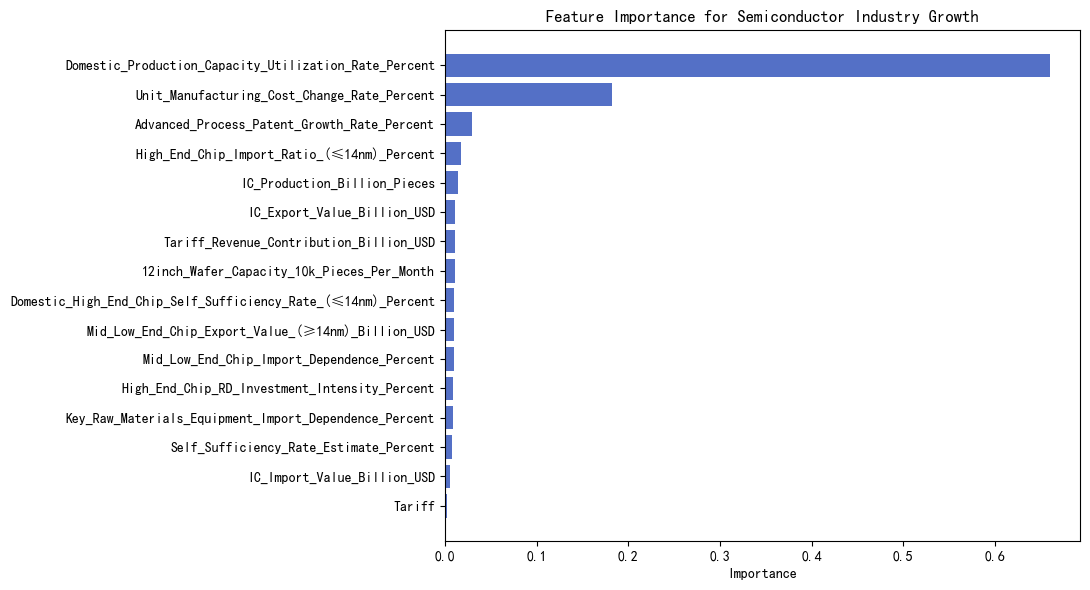

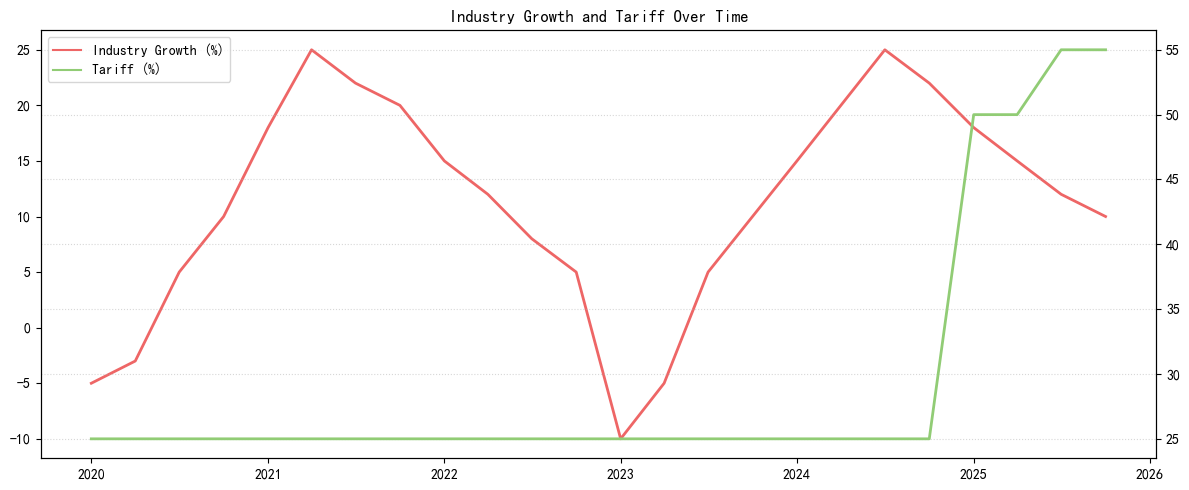

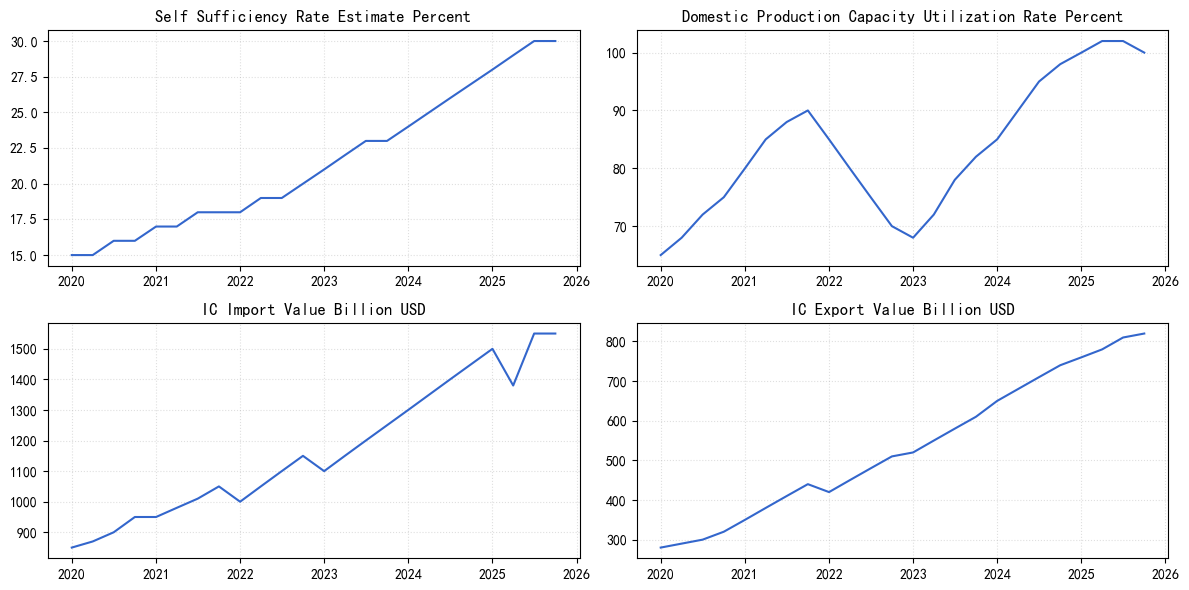

Top features driving industry growth:
- Domestic_Production_Capacity_Utilization_Rate_Percent: 0.6600
- Unit_Manufacturing_Cost_Change_Rate_Percent: 0.1826
- Advanced_Process_Patent_Growth_Rate_Percent: 0.0290
- High_End_Chip_Import_Ratio_(≤14nm)_Percent: 0.0175
- IC_Production_Billion_Pieces: 0.0144
- IC_Export_Value_Billion_USD: 0.0113
- Tariff_Revenue_Contribution_Billion_USD: 0.0113
- 12inch_Wafer_Capacity_10k_Pieces_Per_Month: 0.0112


In [13]:
# 简化版：以 temp.md 框架为指导，完成数据加载→特征自动选择→
# 随机森林/线性回归特征重要性→基础可视化
# 数据：e:\RESEARCH\APMCM\Math_Modeling_APMCM\data\raw\Q3\Q3_Data_English_Headers.csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 尝试使用随机森林；如不可用，退化为线性回归系数/相关系数作为重要性
try:
    from sklearn.ensemble import RandomForestRegressor
    SKLEARN_AVAILABLE = True
except Exception:
    SKLEARN_AVAILABLE = False

# 读取数据
csv_path = Path(r"e:\RESEARCH\APMCM\Math_Modeling_APMCM\data\raw\Q3\Q3_Data_English_Headers.csv")
df = pd.read_csv(csv_path)

# 基础清洗：去除两列非数值列，其他列转换为数值
# 说明：保留 Year/Quarter，后续构造时间轴；其余列统一 to_numeric
numeric_cols = [c for c in df.columns if c not in ["Year", "Quarter"]]
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=numeric_cols, how="any").copy()

# 构造时间序列索引（Year + Quarter → 时间点）
# 用于折线图横轴（英文标签）
quarter_map = {"Q1": 1, "Q2": 4, "Q3": 7, "Q4": 10}
df["MonthIdx"] = df["Quarter"].map(quarter_map).astype(int)
df["Date"] = pd.to_datetime(df["Year"].astype(int).astype(str) + "-" + df["MonthIdx"].astype(int).astype(str) + "-01")
df = df.sort_values("Date").set_index("Date")

# 自动选择目标与特征
# 目标：半导体产业增长率（Semiconductor_Industry_Growth_Rate_Percent）
target_col = "Semiconductor_Industry_Growth_Rate_Percent"
# 特征：排除 Year/Quarter 及目标本身，保留剩余数值列
exclude = {target_col}
feature_cols = [c for c in numeric_cols if c not in exclude]

X = df[feature_cols].astype(float).copy()
y = df[target_col].astype(float).copy()

# 特征重要性（首选随机森林；否则使用线性回归系数或相关系数）
if SKLEARN_AVAILABLE:
    rf = RandomForestRegressor(n_estimators=300, random_state=42)
    rf.fit(X, y)
    importance = rf.feature_importances_
    imp_df = pd.DataFrame({"feature": feature_cols, "importance": importance}).sort_values("importance", ascending=False)
else:
    # 无 sklearn 时，使用标准化线性回归系数近似重要性；若出现奇异矩阵则退化为相关系数绝对值
    X_std = (X - X.mean()) / (X.std(ddof=1).replace(0, 1))
    y_std = (y - y.mean()) / (y.std(ddof=1) if y.std(ddof=1) != 0 else 1)
    try:
        coef = np.linalg.pinv(X_std.values) @ y_std.values
        imp = np.abs(coef)
        imp_df = pd.DataFrame({"feature": feature_cols, "importance": imp}).sort_values("importance", ascending=False)
    except Exception:
        corr = X.corrwith(y).abs().fillna(0.0)
        imp_df = pd.DataFrame({"feature": feature_cols, "importance": corr.values}).sort_values("importance", ascending=False)

# 简单可视化（英文标签，非阻塞式）
# 1) 特征重要性
plt.figure(figsize=(11, 6))
plt.barh(imp_df["feature"], imp_df["importance"], color="#5470C6")
plt.gca().invert_yaxis()
plt.title("Feature Importance for Semiconductor Industry Growth")
plt.xlabel("Importance")
plt.tight_layout()
plt.show(block=False)

# 2) 目标与关税的时间序列（双轴）
plt.figure(figsize=(12, 5))
t = df.index
plt.plot(t, df[target_col].values, label="Industry Growth (%)", color="#EE6666", linewidth=2)
ax2 = plt.twinx()
plt.plot(t, df["Tariff"].values, label="Tariff (%)", color="#91CC75", linewidth=2)
plt.title("Industry Growth and Tariff Over Time")
plt.grid(True, linestyle=":", alpha=0.5)
# 合并图例
lns = [plt.Line2D([], [], color="#EE6666", label="Industry Growth (%)"),
       plt.Line2D([], [], color="#91CC75", label="Tariff (%)")]
plt.legend(handles=lns, loc="best")
plt.tight_layout()
plt.show(block=False)

# 3) 关键变量趋势（二维子图）
key_vars = [
    "Self_Sufficiency_Rate_Estimate_Percent",
    "Domestic_Production_Capacity_Utilization_Rate_Percent",
    "IC_Import_Value_Billion_USD",
    "IC_Export_Value_Billion_USD",
]
plt.figure(figsize=(12, 6))
for i, kv in enumerate(key_vars, start=1):
    ax = plt.subplot(2, 2, i)
    ax.plot(df.index, df[kv].values, color="#3366CC")
    ax.set_title(kv.replace("_", " "))
    ax.grid(True, linestyle=":", alpha=0.4)
plt.tight_layout()
plt.show(block=False)

# 4) 简要结论输出（Top-N特征）
top_n = 8
print("Top features driving industry growth:")
for i, row in imp_df.head(top_n).iterrows():
    print(f"- {row['feature']}: {row['importance']:.4f}")

接下来引入博弈论的框架


In [23]:
# 功能：数据加载、特征权重、2D支付构造、零和博弈求解、热图绘制（非阻塞）
# 语言：中文注释，英文绘图标签；满足项目规则

from __future__ import annotations
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ========= 数据加载与清理 =========
def load_raw(path: Path | str | None = None) -> pd.DataFrame:
    """加载Q3原始数据；默认 data/raw/Q3/Q3_Data_English_Headers.csv"""
    if path is None:
        repo_root = Path(__file__).resolve().parents[2]  # notebook 下两级回到仓库根
        path = repo_root / "data" / "raw" / "Q3" / "Q3_Data_English_Headers.csv"
    p = Path(path)
    if p.suffix.lower() == ".xlsx":
        return pd.read_excel(p)
    return pd.read_csv(p)

def extract_numeric(cell) -> float:
    """提取纯数值；失败返回 NaN"""
    if pd.isna(cell):
        return float("nan")
    if isinstance(cell, (int, float)):
        return float(cell)
    s = str(cell).strip()
    m = re.search(r"^-?\d+(\.\d+)?$", s)
    if m:
        return float(m.group())
    s2 = re.sub(r"[^\d.-]", "", s)
    if s2 and re.match(r"^-?\d+(\.\d+)?$", s2):
        return float(s2)
    return float("nan")

def clean_numeric(df: pd.DataFrame, min_numeric_ratio: float = 0.5) -> pd.DataFrame:
    """将可解析为数值的列转为 float；保留数值占比>阈值；缺失用中位数填充"""
    out = df.copy()
    keep: list[str] = []
    for col in out.columns:
        out[col] = out[col].apply(extract_numeric)
        if out[col].notna().mean() > min_numeric_ratio:
            keep.append(col)
    out = out[keep].copy()
    for col in out.columns:
        med = out[col].median()
        out[col] = out[col].fillna(med).astype(float)
    return out

# ========= 特征重要性 =========
def pick_target_column(df_num: pd.DataFrame, target_hint: str | None = None) -> str:
    """自动选择目标列；支持关键词提示；否则用关键词集合+方差筛选"""
    cols = list(df_num.columns)
    if target_hint:
        mask = [c for c in cols if target_hint.lower() in c.lower()]
        if mask:
            return mask[0]
    keys = ["growth", "rate", "index", "self", "supply", "value", "产值", "增速", "自给"]
    candidates = [c for c in cols if any(k in c.lower() for k in keys)]
    if candidates:
        var_s = {c: float(np.var(df_num[c].values)) for c in candidates}
        return max(var_s, key=var_s.get)
    var_all = {c: float(np.var(df_num[c].values)) for c in cols}
    return max(var_all, key=var_all.get)

def compute_feature_importance(df_num: pd.DataFrame, target_col: str) -> pd.DataFrame:
    """优先RandomForest；无则回退到绝对相关；输出 Importance 和为1"""
    Xcols = [c for c in df_num.columns if c != target_col]
    X = df_num[Xcols]
    y = df_num[target_col]
    try:
        from sklearn.ensemble import RandomForestRegressor
        from sklearn.model_selection import train_test_split
        rf = RandomForestRegressor(n_estimators=200, max_depth=6, min_samples_split=5, random_state=42)
        Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)
        rf.fit(Xtr, ytr)
        imp = rf.feature_importances_
    except Exception:
        imp = X.corrwith(y).abs().fillna(0.0).values
    out = pd.DataFrame({"Feature_Name": Xcols, "Importance": imp})
    s = float(out["Importance"].sum())
    if s > 0:
        out["Importance"] = out["Importance"] / s
    return out.sort_values("Importance", ascending=False).reset_index(drop=True)

# ========= 从特征权重提取政策权重 =========
def _pick_weight(imp_df: pd.DataFrame, patterns: list[str]) -> float:
    mask = imp_df["Feature_Name"].astype(str).str.lower()
    w = imp_df.loc[mask.str.contains("|".join(patterns)), "Importance"].sum()
    return float(w)

def extract_policy_weights(importance_df: pd.DataFrame) -> dict[str, float]:
    """提取 tariff/subsidy/...；若无法解析则均分"""
    df = importance_df.copy()
    total = float(df["Importance"].sum()) or 1.0
    tariff = _pick_weight(df, ["tariff", "duty", "关税"])
    subsidy = _pick_weight(df, ["subsidy", "grant", "补贴"])
    exportc = _pick_weight(df, ["export control", "sanction", "管制", "禁运", "限制"])
    rd = _pick_weight(df, ["r&d", "research", "研发"])
    demand = _pick_weight(df, ["demand", "market", "自给", "需求"])
    cost = _pick_weight(df, ["cost", "price", "成本"])
    w = {
        "tariff": tariff / total,
        "subsidy": subsidy / total,
        "export": exportc / total,
        "rd": rd / total,
        "demand": demand / total,
        "cost": cost / total,
    }
    if sum(w.values()) == 0:
        w = {k: 1.0 / 6.0 for k in w}
    return w

# ========= 领域占比（经济/安全） =========
def _domain_shares(domain: str) -> tuple[float, float]:
    """低/中/高端：经济/安全占比"""
    d = domain.lower()
    if d == "low":
        return 0.7, 0.3
    if d == "high":
        return 0.3, 0.7
    return 0.5, 0.5

# ========= 2D支付构造（与 temp.py 一致） =========
def build_payoff_matrices_2d(w: dict[str, float], domain: str) -> tuple[list[str], list[str], np.ndarray, np.ndarray]:
    """基于关税+补贴两维；叠加领域经济/安全占比与中国策略调整；零和：B=-A"""
    us_strats = ["Restrict", "Subsidize", "Cooperate"]
    cn_strats = ["Buy", "Counter", "Partial"]
    A = np.zeros((3, 3))  # A 为中国收益；按零和设定为 -us_payoff

    t_w = float(w.get("tariff", 0.0))
    s_w = float(w.get("subsidy", 0.0))
    econ_share, sec_share = _domain_shares(domain)

    def us_base(action: str) -> tuple[float, float, float, float]:
        """返回基础分与权重：(base_e, base_s, econ_w, sec_w)"""
        if action == "Restrict":
            base_e = 9.0 if econ_share > 0.6 else (6.0 if abs(econ_share - 0.5) < 1e-12 else 4.0)
            base_s = 4.0 if sec_share > 0.6 else (6.0 if abs(sec_share - 0.5) < 1e-12 else 8.0)
            econ_w, sec_w = t_w, t_w * 0.8
        elif action == "Subsidize":
            base_e = 4.0 if econ_share > 0.6 else (6.0 if abs(econ_share - 0.5) < 1e-12 else 9.0)
            base_s = 9.0 if sec_share > 0.6 else (6.0 if abs(sec_share - 0.5) < 1e-12 else 4.0)
            econ_w, sec_w = s_w * 0.8, s_w
        else:
            base_e, base_s = 7.0, 7.0
            avg = (t_w + s_w) / 2.0
            econ_w, sec_w = avg, avg
        return base_e, base_s, econ_w, sec_w

    def cn_adjust(action: str) -> float:
        """中国策略调整：Counter=0.6；Buy=1.3；Partial=0.9"""
        if action == "Counter":
            return 0.6
        if action == "Buy":
            return 1.3
        return 0.9

    for i, us_a in enumerate(us_strats):
        base_e, base_s, ew, sw = us_base(us_a)
        for j, cn_a in enumerate(cn_strats):
            adj = cn_adjust(cn_a)
            us_payoff = base_e * adj * ew * econ_share + base_s * adj * sw * sec_share
            A[i, j] = -us_payoff  # 中国收益 = -美国收益（零和）

    B = -A.copy()  # 美国收益矩阵
    return us_strats, cn_strats, A, B

# ========= 零和博弈求解 =========
def find_pure_saddle(A: np.ndarray) -> list[tuple[int, int]]:
    """纯策略鞍点：列最大且行最小"""
    eq: list[tuple[int, int]] = []
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if A[i, j] >= A[:, j].max() - 1e-12 and A[i, j] <= A[i, :].min() + 1e-12:
                eq.append((i, j))
    return eq

def solve_zero_sum_equilibrium(A: np.ndarray) -> dict:
    """求解零和：纯策略鞍点+混合策略（nashpy 可用则调用）"""
    results = {"pure": [], "mixed": []}
    results["pure"] = find_pure_saddle(A)
    try:
        import nashpy as nash
        game = nash.Game(A, -A)
        try:
            p_row, p_col = game.solve_zero_sum()
            results["mixed"] = [(p_row, p_col)]
        except Exception:
            results["mixed"] = list(game.support_enumeration())
    except Exception:
        results["mixed"] = []
    return results

# ========= 非阻塞绘图 =========
def plot_payoff_heatmap(A: np.ndarray, row_labels: list[str], col_labels: list[str], title: str):
    """支付矩阵热图；英文标签；非阻塞显示"""
    plt.figure(figsize=(5.5, 4.5))
    plt.imshow(A, cmap="viridis")
    plt.colorbar(label="Payoff")
    plt.xticks(range(len(col_labels)), col_labels)
    plt.yticks(range(len(row_labels)), row_labels)
    plt.title(title)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            color = "white" if A[i, j] < 0 else "black"
            plt.text(j, i, f"{A[i, j]:.2f}", ha="center", va="center", color=color)
    plt.tight_layout()
    plt.show(block=False)

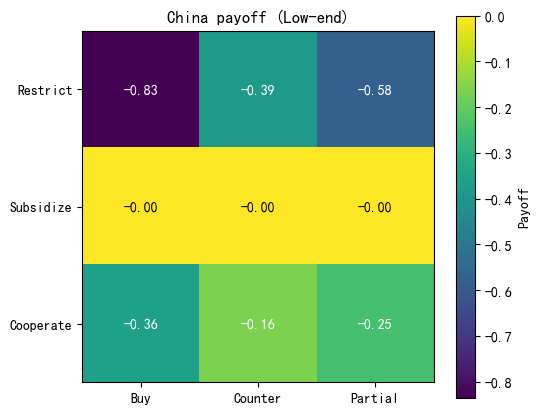

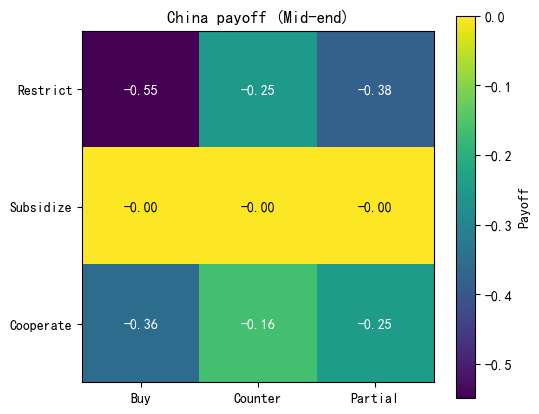

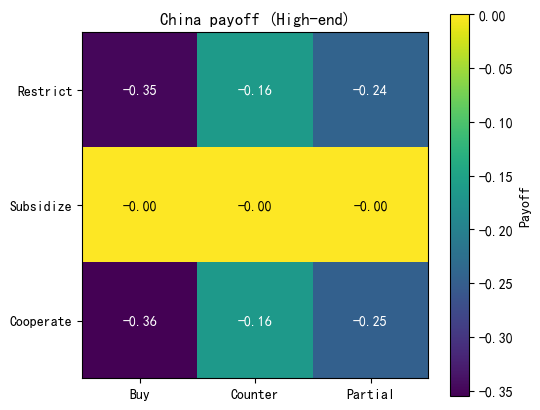

Target column: IC_Import_Value_Billion_USD
[low] Pure-strategy saddle points: [(1, 0), (1, 1), (1, 2)]
[low] Mixed-strategy (first): (array([0., 1., 0.]), array([1., 0., 0.]))
[mid] Pure-strategy saddle points: [(1, 0), (1, 1), (1, 2)]
[mid] Mixed-strategy (first): (array([0., 1., 0.]), array([1., 0., 0.]))
[high] Pure-strategy saddle points: [(1, 0), (1, 1), (1, 2)]
[high] Mixed-strategy (first): (array([0., 1., 0.]), array([1., 0., 0.]))


In [24]:
# 配置路径与可选参数
DATA_PATH = r"e:\RESEARCH\APMCM\Math_Modeling_APMCM\data\raw\Q3\Q3_Data_English_Headers.csv"
TARGET_HINT = None  # 可选：如 'growth' / '自给'

# 1) 数据与权重
df_raw = load_raw(DATA_PATH)
df_num = clean_numeric(df_raw)
target_col = pick_target_column(df_num, target_hint=TARGET_HINT)
imp_df = compute_feature_importance(df_num, target_col=target_col)
base_weights = extract_policy_weights(imp_df)

# 2) 三领域分析（低/中/高端）
domains = ["low", "mid", "high"]
title_map = {
    "low": "China payoff (Low-end)",
    "mid": "China payoff (Mid-end)",
    "high": "China payoff (High-end)",
}

domain_outputs = {}
for d in domains:
    row_d, col_d, A_d, B_d = build_payoff_matrices_2d(base_weights, d)
    results_d = solve_zero_sum_equilibrium(A_d)
    domain_outputs[d] = {"row": row_d, "col": col_d, "A": A_d, "B": B_d, "results": results_d}
    plot_payoff_heatmap(A_d, row_d, col_d, title_map[d])

# 3) 简要结果打印（纯/混合策略）
print(f"Target column: {target_col}")
for d in domains:
    pure = domain_outputs[d]["results"]["pure"]
    mixed = domain_outputs[d]["results"]["mixed"]
    print(f"[{d}] Pure-strategy saddle points:", pure if pure else "None")
    if mixed:
        print(f"[{d}] Mixed-strategy (first):", mixed[0])
    else:
        print(f"[{d}] Mixed-strategy: None or nashpy not available")